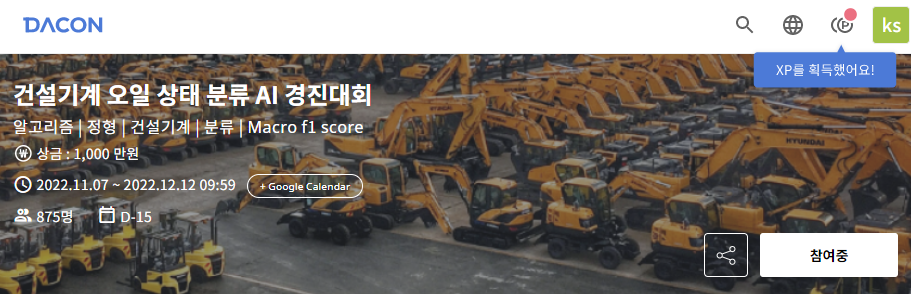

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [81]:
file_version = 35
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,    # 0.01
    'BATCH_SIZE':256,  #256
    'SEED':43,
    'log_transform_turn': 1,  # 로그 트랜스폼을 몇번 돌릴 것인가?
    'skew_cut':0.01,           # 왜도 얼마 이상을 로그값으로 정규화할 것인가?(100이면 안하겠다는 것)
    'vif_cut': 10,           # 다중공선성 vif 얼마 이상을 제거할 것인가?
    'corr_cut': 0.006,     # 일정 상관관계 이하 칼럼은 드랍
    'outlier_corr_cut': 100,    # 이값 이상의 상관관계를 갖는 칼럼에 대해서만 아웃라이어 제거(100이면 미적용)
    'T_Thresh': 0.35,     # Teacher model train Threshhold 최초 0.35
    'S_Thresh': 0.35,     # Student model train Threshold 최초 0.35
    'reduct' : 'mean',      # sum, mean
    'drop_rate': 0.2,
    
}

In [82]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

# 1. EDA

- 결측치 처리
- 왜도 정규화 처리
- 스케일링
- 다중공선성 검토

In [83]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [84]:
train["Y_LABEL"].value_counts()

0    12892
1     1203
Name: Y_LABEL, dtype: int64

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  int64  
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [86]:
# test.info()

## (1) 결측치

<AxesSubplot:>

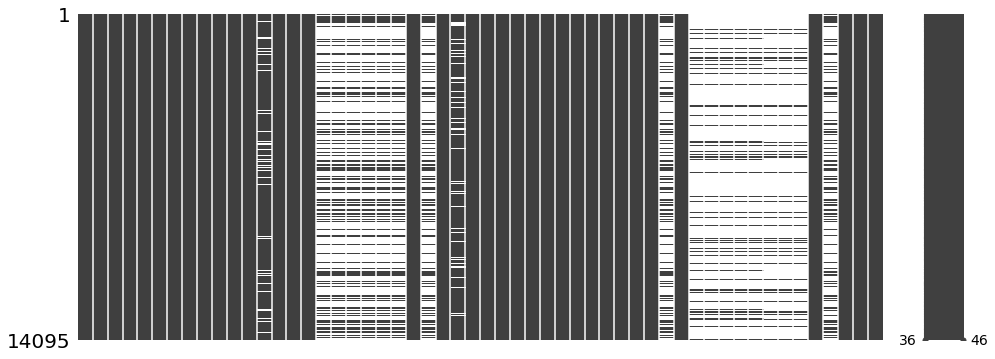

In [87]:
import missingno as msno
msno.matrix(train, figsize=(16,6))

In [88]:
train.describe(include="all")

ID COMPONENT_ARBITRARY    ANONYMOUS_1          YEAR  \
count         14095               14095   14095.000000  14095.000000   
unique        14095                   4            NaN           NaN   
top     TRAIN_00000          COMPONENT3            NaN           NaN   
freq              1                7050            NaN           NaN   
mean            NaN                 NaN    3146.082937   2013.652501   
std             NaN                 NaN    4216.089809      3.964758   
min             NaN                 NaN    1000.000000   2007.000000   
25%             NaN                 NaN    1655.000000   2010.000000   
50%             NaN                 NaN    2227.000000   2014.000000   
75%             NaN                 NaN    3797.000000   2017.000000   
max             NaN                 NaN  294451.000000   2022.000000   

        SAMPLE_TRANSFER_DAY   ANONYMOUS_2            AG            AL  \
count          14095.000000  14095.000000  14095.000000  14095.000000   
unique                  NaN           NaN           NaN           NaN   
top                     NaN           NaN           NaN           NaN   
freq                    NaN           NaN           NaN           NaN   
mean               7.600568    387.416885      0.025825     12.707698   
std               11.681628    550.016073      0.171926     86.968000   
min                0.000000    200.000000      0.000000      0.000000   
25%                3.000000    200.000000      0.000000      1.000000   
50%                5.000000    200.000000      0.000000      2.000000   
75%                8.000000    410.000000      0.000000      4.000000   
max              368.000000   9650.000000      3.000000   4630.000000   

                   B            BA  ...          U25          U20  \
count   14095.000000  14095.000000  ...  2316.000000  2316.000000   
unique           NaN           NaN  ...          NaN          NaN   
top              NaN           NaN  ...          NaN          NaN   
freq             NaN           NaN  ...          NaN          NaN   
mean       64.026179      0.692799  ...    29.870898    56.063472   
std       102.876871      2.905491  ...    97.459625   184.332678   
min         0.000000      0.000000  ...     0.000000     0.000000   
25%         3.000000      0.000000  ...     3.000000     5.000000   
50%        11.000000      0.000000  ...     7.000000    13.000000   
75%       110.000000      0.000000  ...    23.000000    39.250000   
max      2051.000000    216.000000  ...  1651.000000  2932.000000   

                 U14             U6             U4             V         V100  \
count    2118.000000    2118.000000    2118.000000  14095.000000  3724.000000   
unique           NaN            NaN            NaN           NaN          NaN   
top              NaN            NaN            NaN           NaN          NaN   
freq             NaN            NaN            NaN           NaN          NaN   
mean      239.938149    5488.693107   19415.597262      0.050656    13.576230   
std       685.053457   15474.146283   40145.311444      0.475438     1.073718   
min         0.000000      15.000000     154.000000      0.000000     5.200000   
25%        22.000000     636.750000    5409.250000      0.000000    12.900000   
50%        57.000000    1753.000000   12691.500000      0.000000    13.500000   
75%       189.000000    5517.750000   24535.750000      0.000000    14.200000   
max     11296.000000  412627.000000  844421.000000     17.000000    29.900000   

                 V40            ZN       Y_LABEL  
count   14095.000000  14095.000000  14095.000000  
unique           NaN           NaN           NaN  
top              NaN           NaN           NaN  
freq             NaN           NaN           NaN  
mean      109.355815    588.646825      0.085349  
std        49.612379    531.743393      0.279411  
min         2.900000      0.000000      0.000000  
25%        71.800000     37.000000      0.000000  
50%       111.

In [89]:
def 보간값(col):
    평균 = train[col].mean()
    중위수 = train[col].median()
    최빈값 = train[col].mode().values[0]
    return {"평균": 평균, "중위수": 중위수, "최빈값":최빈값}

In [90]:
null_columns = []
for col in train.columns.tolist():
    if train[col].isna().any():
        null_columns.append(col)
        평균 = 보간값(col)["평균"]
        중위수 = 보간값(col)["중위수"]
        최빈값 = 보간값(col)["최빈값"]
        print(f"칼럼명: {col}, 평균: {평균:.2f}, 중위수: {중위수}, 최빈값: {최빈값}")
    else:
        pass   

칼럼명: CD, 평균: 0.02, 중위수: 0.0, 최빈값: 0.0
칼럼명: FH2O, 평균: 15.24, 중위수: 13.0, 최빈값: 14.0
칼럼명: FNOX, 평균: 7.14, 중위수: 7.0, 최빈값: 6.0
칼럼명: FOPTIMETHGLY, 평균: 0.53, 중위수: 0.0, 최빈값: 0.0
칼럼명: FOXID, 평균: 12.50, 중위수: 12.0, 최빈값: 11.0
칼럼명: FSO4, 평균: 20.28, 중위수: 20.0, 최빈값: 20.0
칼럼명: FTBN, 평균: 8.78, 중위수: 8.7, 최빈값: 8.2
칼럼명: FUEL, 평균: 0.19, 중위수: 0.0, 최빈값: 0.0
칼럼명: K, 평균: 3.61, 중위수: 2.0, 최빈값: 0.0
칼럼명: SOOTPERCENTAGE, 평균: 0.61, 중위수: 0.4, 최빈값: 0.2
칼럼명: U100, 평균: 0.17, 중위수: 0.0, 최빈값: 0.0
칼럼명: U75, 평균: 0.42, 중위수: 0.0, 최빈값: 0.0
칼럼명: U50, 평균: 6.19, 중위수: 1.0, 최빈값: 0.0
칼럼명: U25, 평균: 29.87, 중위수: 7.0, 최빈값: 1.0
칼럼명: U20, 평균: 56.06, 중위수: 13.0, 최빈값: 4.0
칼럼명: U14, 평균: 239.94, 중위수: 57.0, 최빈값: 14.0
칼럼명: U6, 평균: 5488.69, 중위수: 1753.0, 최빈값: 300.0
칼럼명: U4, 평균: 19415.60, 중위수: 12691.5, 최빈값: 6789.0
칼럼명: V100, 평균: 13.58, 중위수: 13.5, 최빈값: 13.3


In [91]:
train[null_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CD              12701 non-null  float64
 1   FH2O            3890 non-null   float64
 2   FNOX            3890 non-null   float64
 3   FOPTIMETHGLY    3890 non-null   float64
 4   FOXID           3890 non-null   float64
 5   FSO4            3890 non-null   float64
 6   FTBN            3890 non-null   float64
 7   FUEL            3890 non-null   float64
 8   K               11796 non-null  float64
 9   SOOTPERCENTAGE  3890 non-null   float64
 10  U100            2316 non-null   float64
 11  U75             2316 non-null   float64
 12  U50             2316 non-null   float64
 13  U25             2316 non-null   float64
 14  U20             2316 non-null   float64
 15  U14             2118 non-null   float64
 16  U6              2118 non-null   float64
 17  U4              2118 non-null  

In [92]:
print(null_columns)

['CD', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'K', 'SOOTPERCENTAGE', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V100']


In [93]:

# for i in null_columns:
#     print(train.groupby(by=["COMPONENT_ARBITRARY"])[i].agg(pd.Series.mode))

In [94]:
# df2=train.groupby(["COMPONENT_ARBITRARY","YEAR"])[["FTBN"]].mean()
# import scipy.stats
# df2 = train.groupby(["COMPONENT_ARBITRARY","YEAR"])["CD"].agg(lambda x: scipy.stats.mode(x)[0][0])
# df2 = train.groupby(["COMPONENT_ARBITRARY","YEAR"])["FTBN"].agg(pd.Series.mode)

# df2.head(50)

In [95]:
for i in null_columns:
#     print(train.groupby("COMPONENT_ARBITRARY")[i].median())

    train[i].fillna(train.groupby(["COMPONENT_ARBITRARY","YEAR"])[i].transform("median"),inplace=True)
#     train[i].fillna(train.groupby("COMPONENT_ARBITRARY")[[i]].mean()

In [96]:
train[null_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CD              14095 non-null  float64
 1   FH2O            3890 non-null   float64
 2   FNOX            3890 non-null   float64
 3   FOPTIMETHGLY    3890 non-null   float64
 4   FOXID           3890 non-null   float64
 5   FSO4            3890 non-null   float64
 6   FTBN            3890 non-null   float64
 7   FUEL            3890 non-null   float64
 8   K               14095 non-null  float64
 9   SOOTPERCENTAGE  3890 non-null   float64
 10  U100            2316 non-null   float64
 11  U75             2316 non-null   float64
 12  U50             2316 non-null   float64
 13  U25             2316 non-null   float64
 14  U20             2316 non-null   float64
 15  U14             2316 non-null   float64
 16  U6              2316 non-null   float64
 17  U4              2316 non-null  

In [97]:
# nan 보간 : 평균 or 중위수 or 최빈값
# 보간값적용 = "최빈값"
# result = []
# def 보간값대체(val):
#     for col in null_columns:
#         a = 보간값(col)[val] # 최빈값
# #         print(a)
#         train[col] = train[col].fillna(a)
#         result.append(a)
#     return result
# print(보간값대체(보간값적용))

<AxesSubplot:>

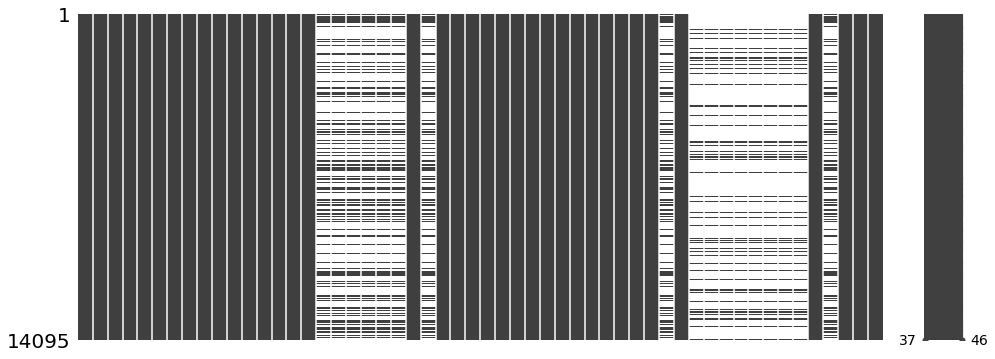

In [98]:
msno.matrix(train, figsize=(16,6))

In [99]:
null_columns = []
for col in train.columns.tolist():
    if train[col].isna().any():
        null_columns.append(col)
        평균 = 보간값(col)["평균"]
        중위수 = 보간값(col)["중위수"]
        최빈값 = 보간값(col)["최빈값"]
        print(f"칼럼명: {col}, 평균: {평균:.2f}, 중위수: {중위수}, 최빈값: {최빈값}")
    else:
        pass   

칼럼명: FH2O, 평균: 15.24, 중위수: 13.0, 최빈값: 14.0
칼럼명: FNOX, 평균: 7.14, 중위수: 7.0, 최빈값: 6.0
칼럼명: FOPTIMETHGLY, 평균: 0.53, 중위수: 0.0, 최빈값: 0.0
칼럼명: FOXID, 평균: 12.50, 중위수: 12.0, 최빈값: 11.0
칼럼명: FSO4, 평균: 20.28, 중위수: 20.0, 최빈값: 20.0
칼럼명: FTBN, 평균: 8.78, 중위수: 8.7, 최빈값: 8.2
칼럼명: FUEL, 평균: 0.19, 중위수: 0.0, 최빈값: 0.0
칼럼명: SOOTPERCENTAGE, 평균: 0.61, 중위수: 0.4, 최빈값: 0.2
칼럼명: U100, 평균: 0.17, 중위수: 0.0, 최빈값: 0.0
칼럼명: U75, 평균: 0.42, 중위수: 0.0, 최빈값: 0.0
칼럼명: U50, 평균: 6.19, 중위수: 1.0, 최빈값: 0.0
칼럼명: U25, 평균: 29.87, 중위수: 7.0, 최빈값: 1.0
칼럼명: U20, 평균: 56.06, 중위수: 13.0, 최빈값: 4.0
칼럼명: U14, 평균: 224.54, 중위수: 57.0, 최빈값: 51.0
칼럼명: U6, 평균: 5180.34, 중위수: 1784.0, 최빈값: 1784.0
칼럼명: U4, 평균: 19061.03, 중위수: 13261.5, 최빈값: 18066.0
칼럼명: V100, 평균: 13.58, 중위수: 13.6, 최빈값: 13.7


In [100]:
train.drop(columns = null_columns, axis = 1, inplace = True)

In [101]:
train.columns, train.shape

(Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR',
        'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA',
        'CD', 'CO', 'CR', 'CU', 'FE', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA',
        'NI', 'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40',
        'ZN', 'Y_LABEL'],
       dtype='object'),
 (14095, 37))

In [102]:
# for i in null_columns:
# #     print(train.groupby("COMPONENT_ARBITRARY")[i].median())
#     최빈값 = train[i].mode().values[0]
#     중위값 = train[i].median()
#     평균값 = train[i].mean()
#     train[i].fillna(중위값, inplace=True)
# #     train[i].fillna(train.groupby("COMPONENT_ARBITRARY")[[i]].mean()

<AxesSubplot:>

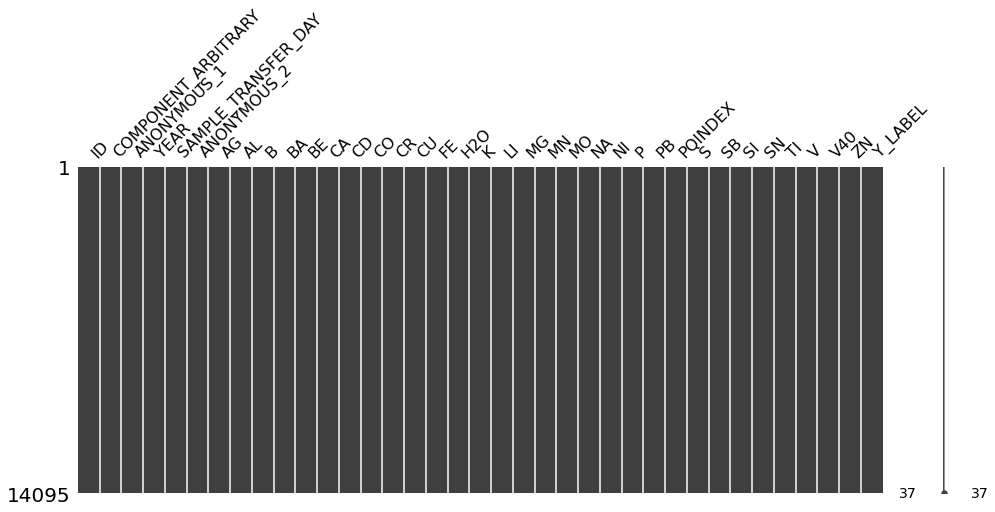

In [103]:
msno.matrix(train, figsize=(16,6))

In [104]:
# null_columns = []
# for col in train.columns.tolist():
#     if train[col].isna().any():
#         null_columns.append(col)
#         평균 = 보간값(col)["평균"]
#         중위수 = 보간값(col)["중위수"]
#         최빈값 = 보간값(col)["최빈값"]
#         print(f"칼럼명: {col}, 평균: {평균:.2f}, 중위수: {중위수}, 최빈값: {최빈값}")
#     else:
#         pass   

In [105]:
y1 = [2019, 2020, 2022, 2021, 2007]
y2 = [2017, 2018, 2016]
y3 = [2015, 2012, 2013]
y4 = [2011, 2014]
y5 = [2010, 2009, 2008]

def year_grouping(year):
    if year in y1:
        return "y1"
    elif year in y2:
        return "y2"
    elif year in y3:
        return "y3"
    elif year in y4:
        return "y4"
    else:
        return "y5" 

In [106]:
train["YEAR"] = train["YEAR"].apply(year_grouping)
train["YEAR"].value_counts()

y3    3418
y5    3234
y2    2716
y4    2546
y1    2181
Name: YEAR, dtype: int64

In [107]:
test["YEAR"] = test["YEAR"].apply(year_grouping)
test["YEAR"].value_counts()

y3    1494
y5    1404
y2    1155
y4    1032
y1     956
Name: YEAR, dtype: int64

In [108]:
s1 = [2, 3, 4, 5, 6]
s2 = [1, 7, 8, 9, 10, 11, 12, 13, 14]

def sample_day_grouping(day):
    if day in s1:
        return "s1"
    elif day in s2:
        return "s2"
    else:
        return "s3" 


In [109]:
train["SAMPLE_TRANSFER_DAY"] = train["SAMPLE_TRANSFER_DAY"].apply(sample_day_grouping)
train["SAMPLE_TRANSFER_DAY"].value_counts()

s1    8313
s2    4614
s3    1168
Name: SAMPLE_TRANSFER_DAY, dtype: int64

## (2) 왜도 검토 - `Log Transform`

In [110]:
# not_number_features = ['ID','COMPONENT_ARBITRARY', 'YEAR', "Y_LABEL"]
not_number_features = ['ID','COMPONENT_ARBITRARY', 'SAMPLE_TRANSFER_DAY','YEAR', "Y_LABEL"]

numerical_cols = list(set(train.columns.tolist())-set(not_number_features))
print(numerical_cols)
print(len(numerical_cols))

['FE', 'K', 'CR', 'P', 'NA', 'SI', 'ZN', 'CO', 'MO', 'SB', 'AG', 'SN', 'BE', 'MG', 'V', 'H2O', 'PQINDEX', 'S', 'V40', 'PB', 'AL', 'ANONYMOUS_2', 'B', 'CU', 'CA', 'BA', 'CD', 'TI', 'NI', 'MN', 'LI', 'ANONYMOUS_1']
32


In [111]:
#박스 플롯
def box_plot(df):
    세로열 = 3
    가로열 = int(len(numerical_cols)/세로열+1)

    fig, axes = plt.subplots(가로열, 3, figsize=(18, 30))
    a = 0
    for i, col in enumerate(numerical_cols):
            b=i%3
            sns.boxplot(ax=axes[a, b], data=df, x='Y_LABEL', y=col)
            if b == 2:
                a += 1

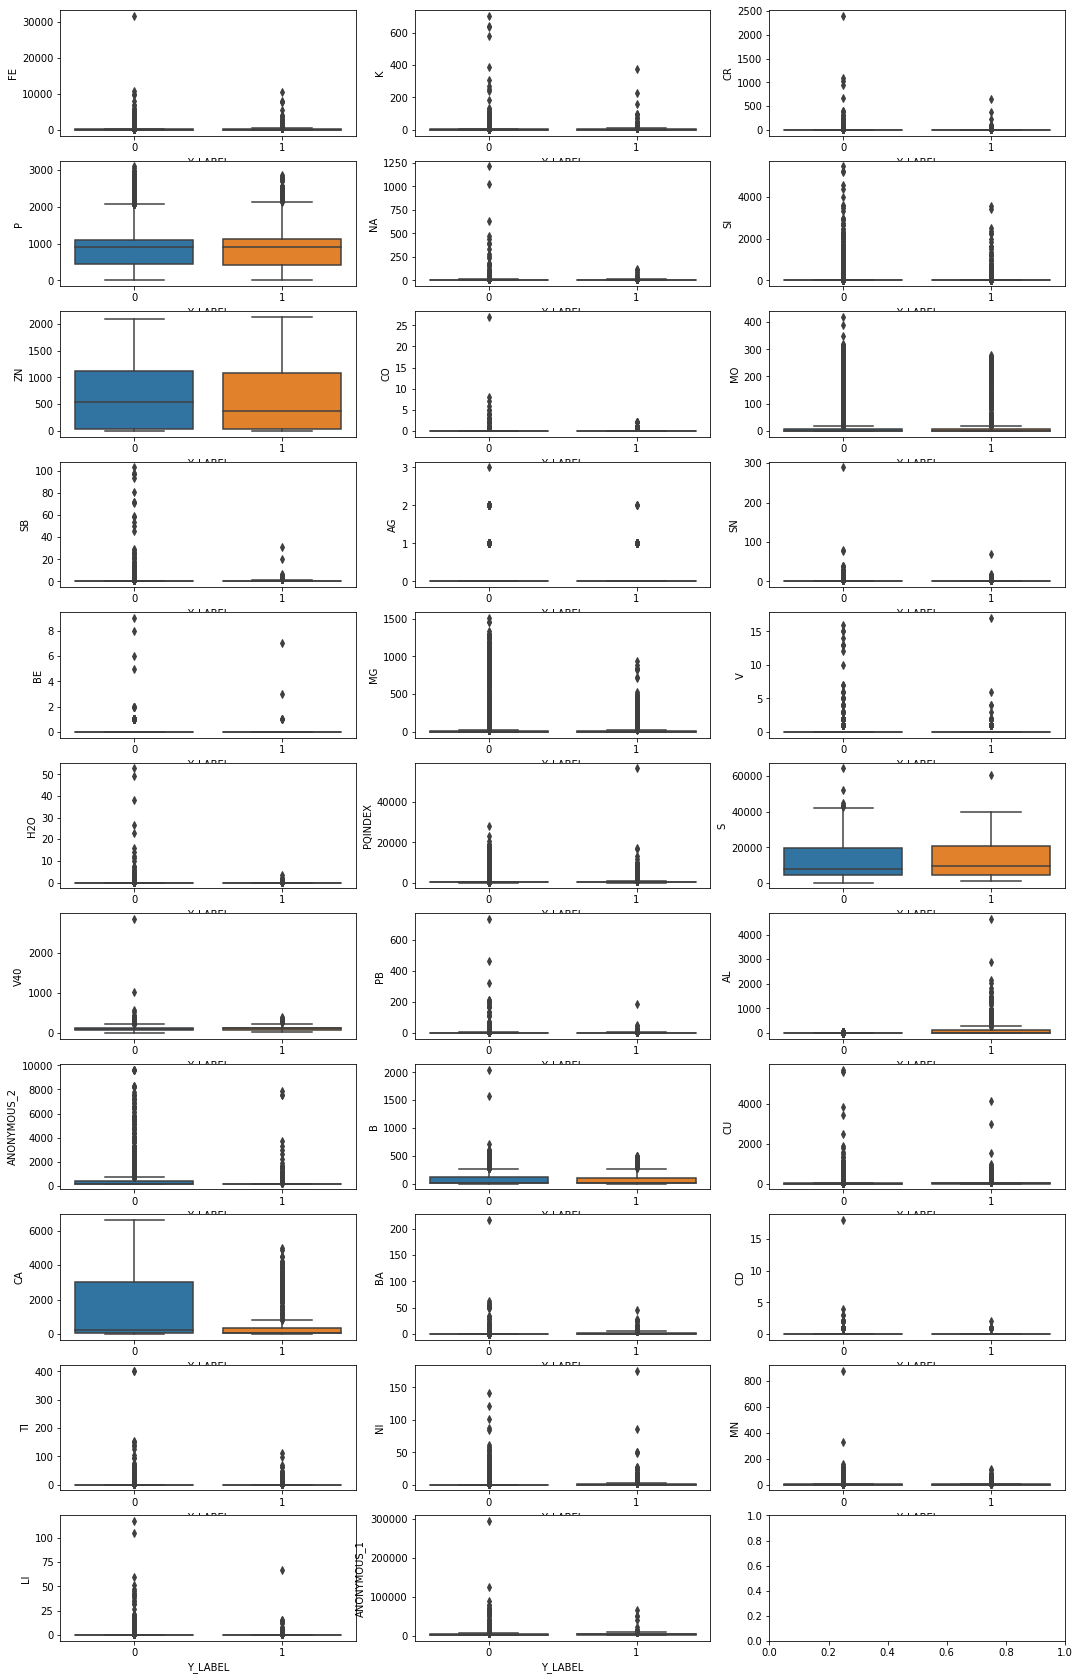

In [112]:
box_plot(train)

In [113]:
def skew_chart(df):
    세로열 = 3
    가로열 = int(len(df.columns)/세로열+1)

    fig, axes = plt.subplots(가로열, 3, figsize=(20, 30))
    a = 0
    for i, col in enumerate(skew_feats):
        b=i%3
        sns.distplot(df[col], bins=100, ax=axes[a, b])
        plt.gca().set_title(col)
        plt.subplots_adjust(hspace = 0.8)
        if b == 2:
            a += 1

In [114]:
# skew_chart(train)

In [115]:
skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skewness

CD             55.899106
CR             54.368366
CO             49.810892
H2O            48.656666
NA             43.060333
BE             40.923712
SN             39.878475
PB             39.602904
MN             38.915313
BA             34.836012
TI             34.500761
K              31.103198
ANONYMOUS_1    30.451948
LI             28.675390
SB             25.174375
AL             22.037843
V              20.985827
CU             20.741422
NI             20.387033
FE             20.119119
SI             13.847020
V40            12.987017
PQINDEX         9.829113
ANONYMOUS_2     8.529989
AG              7.309733
MG              6.095664
MO              2.904525
B               2.847296
P               1.149380
S               0.806596
CA              0.390928
ZN              0.227683
dtype: float64

In [116]:
for i in tqdm(range(CFG["log_transform_turn"])):
    skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
    skew_feats = skewness[skewness > CFG["skew_cut"]].index
    
    log_train = train[skew_feats].copy()
    log_train[skew_feats] = np.log1p(log_train[skew_feats])
        
    for col in skew_feats:
        train[col] = log_train[col]
    
    skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
#     print("-"*40)
#     print(skew_feats)
    print(skewness)
    
    for col in skew_feats:
        if col in test.columns:
            test[col] = np.log1p(test[col])
        else:
            pass

  0%|          | 0/1 [00:00<?, ?it/s]

BE             23.412466
H2O            18.578013
CD             11.885586
CO              9.008246
V               8.296009
AG              6.600190
LI              5.496954
TI              4.836962
NI              2.881386
SB              2.767385
BA              2.176642
SN              2.044310
AL              1.782754
ANONYMOUS_2     1.779987
PB              1.681511
MN              1.387217
CR              1.309447
SI              1.239047
MO              1.197475
MG              0.960658
ANONYMOUS_1     0.930168
K               0.916212
PQINDEX         0.786814
CU              0.763561
NA              0.605474
FE              0.273557
B               0.168986
CA             -0.201518
S              -0.324163
V40            -0.496896
ZN             -0.501953
P              -0.622552
dtype: float64


In [117]:
# skew_chart(train)

## (3) Scaling

In [118]:
categorical_features = ['ID','COMPONENT_ARBITRARY','SAMPLE_TRANSFER_DAY', 'YEAR', "Y_LABEL"]

In [119]:
train.head(2)

ID COMPONENT_ARBITRARY  ANONYMOUS_1 YEAR SAMPLE_TRANSFER_DAY  \
0  TRAIN_00000          COMPONENT3     7.304516   y4                  s2   
1  TRAIN_00001          COMPONENT2     7.208600   y1                  s3   

   ANONYMOUS_2   AG        AL         B   BA  ...   PQINDEX         S   SB  \
0     5.303305  0.0  1.386294  4.543295  0.0  ...  9.048410  9.969790  0.0   
1     5.929589  0.0  1.098612  2.995732  0.0  ...  2.995732  7.019297  0.0   

         SI        SN        TI    V       V40        ZN  Y_LABEL  
0  6.059123  1.098612  1.791759  0.0  5.043425  4.330733        0  
1  0.000000  0.000000  0.000000  0.0  3.806662  6.481577        0  

[2 rows x 37 columns]

In [120]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train.columns:
    if col not in categorical_features:   # 범주형 칼럼이 아니라면 표준화
        scaler = StandardScaler()
        train[col] = scaler.fit_transform(get_values(train[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
train.head(2)

ID COMPONENT_ARBITRARY  ANONYMOUS_1 YEAR SAMPLE_TRANSFER_DAY  \
0  TRAIN_00000          COMPONENT3    -0.912752   y4                  s2   
1  TRAIN_00001          COMPONENT2    -1.076829   y1                  s3   

   ANONYMOUS_2        AG        AL         B       BA  ...   PQINDEX  \
0    -0.623928 -0.153746  0.144147  0.961928 -0.49312  ...  2.758639   
1     0.405018 -0.153746 -0.117480  0.116099 -0.49312  ... -0.524164   

          S        SB        SI        SN        TI         V       V40  \
0  1.029866 -0.457769  3.161120  1.224939  3.210181 -0.154507  1.007861   
1 -2.246986 -0.457769 -1.685121 -0.549480 -0.264003 -0.154507 -1.939387   

         ZN  Y_LABEL  
0 -0.614230        0  
1  0.606862        0  

[2 rows x 37 columns]

## (4) 다중공선성 검토

In [121]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [122]:
train1 = train.copy()

In [123]:
train1 = train1[numerical_cols].astype(float)
train1.shape

(14095, 32)

In [124]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train1.values, i) for i in range(train1.shape[1])]
vif["features"] = train1.columns 
vif

VIF Factor     features
0     6.623440           FE
1     1.558002            K
2     3.005376           CR
3     1.781246            P
4     1.406679           NA
5     3.055155           SI
6     5.043949           ZN
7     1.180463           CO
8     1.703314           MO
9     1.169121           SB
10    1.020925           AG
11    1.618269           SN
12    1.010795           BE
13    2.094131           MG
14    1.520136            V
15    1.095039          H2O
16    3.860271      PQINDEX
17    4.755446            S
18    3.478362          V40
19    1.791675           PB
20    1.214049           AL
21    1.068324  ANONYMOUS_2
22    1.165714            B
23    1.755174           CU
24    1.170602           CA
25    1.278613           BA
26    1.027132           CD
27    2.793037           TI
28    2.563418           NI
29    4.838386           MN
30    1.085231           LI
31    1.137721  ANONYMOUS_1

In [125]:
vif_10이상 = vif[vif["VIF Factor"]> CFG["vif_cut"]]
vif_drop = vif_10이상["features"].tolist()
vif_drop

[]

In [126]:
train1 = train1.drop(vif_drop,axis=1)

In [127]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train1.values, i) for i in range(train1.shape[1])]
vif["features"] = train1.columns 
vif.T

0         1         2         3         4         5   \
VIF Factor  6.62344  1.558002  3.005376  1.781246  1.406679  3.055155   
features         FE         K        CR         P        NA        SI   

                  6         7         8         9   ...        22        23  \
VIF Factor  5.043949  1.180463  1.703314  1.169121  ...  1.165714  1.755174   
features          ZN        CO        MO        SB  ...         B        CU   

                  24        25        26        27        28        29  \
VIF Factor  1.170602  1.278613  1.027132  2.793037  2.563418  4.838386   
features          CA        BA        CD        TI        NI        MN   

                  30           31  
VIF Factor  1.085231     1.137721  
features          LI  ANONYMOUS_1  

[2 rows x 32 columns]

In [128]:
# VIF 높은 칼럼 드랍
train.drop(vif_drop ,axis=1, inplace=True)

In [129]:
print(f"드랍하기 전 칼럼 갯수 : {len(test.columns)}")
for col in vif_drop:
    if col in test.columns:
        test.drop(columns = col, axis = 1, inplace = True)
    else:
        pass
print(f"드랍후 칼럼 갯수 : {len(test.columns)}")

드랍하기 전 칼럼 갯수 : 19
드랍후 칼럼 갯수 : 19


## (5) 상관관계 검토

In [130]:
train.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR',
       'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FE', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA',
       'NI', 'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40',
       'ZN', 'Y_LABEL'],
      dtype='object')

<AxesSubplot:>

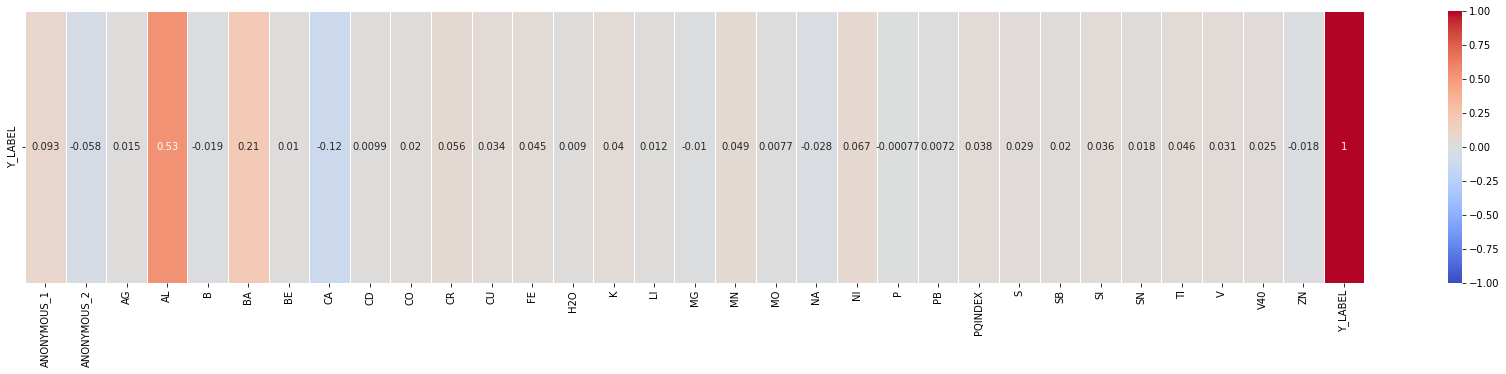

In [131]:
fig = plt.figure(figsize=(30, 5))
sns.heatmap(train.loc[:,:].corr()[["Y_LABEL"]].T, annot=True, linewidth=1, cmap="coolwarm", vmin=-1, vmax=1)

In [132]:
df_corr = pd.DataFrame(train.corr()["Y_LABEL"].sort_values(ascending=False))
df_corr

Y_LABEL
Y_LABEL      1.000000
AL           0.531680
BA           0.205176
ANONYMOUS_1  0.092820
NI           0.067153
CR           0.056019
MN           0.048509
TI           0.046066
FE           0.045108
K            0.039991
PQINDEX      0.037558
SI           0.036470
CU           0.033862
V            0.031353
S            0.028680
V40          0.024576
CO           0.019653
SB           0.019587
SN           0.017692
AG           0.015292
LI           0.011860
BE           0.010184
CD           0.009921
H2O          0.009037
MO           0.007714
PB           0.007244
P           -0.000769
MG          -0.010150
ZN          -0.018060
B           -0.018961
NA          -0.028494
ANONYMOUS_2 -0.058001
CA          -0.123297

In [133]:
# 상관관계가 낮아서 제낄 칼럼 확인
cutline = CFG["corr_cut"]
df_corr1 = df_corr[(df_corr["Y_LABEL"] < cutline) & (df_corr["Y_LABEL"] > (cutline*-1))]
print(f"상관계수 커트라인 : {cutline}, 드랍 칼럼 개수 : {len(df_corr1.index)}")
df_corr1.sort_values

상관계수 커트라인 : 0.006, 드랍 칼럼 개수 : 1


<bound method DataFrame.sort_values of     Y_LABEL
P -0.000769>

In [134]:
drop_columns = df_corr1.index.tolist()
drop_columns

['P']

In [135]:
print(f"드랍하기 전 칼럼 갯수 : {len(train.columns)}")
for col in drop_columns:
    if col in train.columns:
        train.drop(columns = col, axis = 1, inplace = True)
    else:
        pass
print(f"드랍후 칼럼 갯수 : {len(train.columns)}")

드랍하기 전 칼럼 갯수 : 37
드랍후 칼럼 갯수 : 36


In [136]:
print(f"드랍하기 전 칼럼 갯수 : {len(test.columns)}")
for col in drop_columns:
    if col in test.columns:
        test.drop(columns = col, axis = 1, inplace = True)
    else:
        pass
print(f"드랍후 칼럼 갯수 : {len(test.columns)}")

드랍하기 전 칼럼 갯수 : 19
드랍후 칼럼 갯수 : 19


In [137]:
# 상관관계 낮은 칼럼 드랍
# train.drop(df_corr1.index.tolist(), axis = 1, inplace=True)
# train.columns

## (6) 수치형 데이터 이상치 처리

In [138]:
not_number_features = ['ID','COMPONENT_ARBITRARY', 'SAMPLE_TRANSFER_DAY','YEAR', "Y_LABEL"]
train.drop(columns = "ID", axis = 1, inplace = True)
test.drop(columns = "ID", axis = 1, inplace = True)

In [139]:
#이상치 인덱스 확인 함수
def get_outlier(df=None, col=None, weight=1.5):
    target = df[col]
    quantile_25 = np.quantile(target, 0.25)
    quantile_75 = np.quantile(target, 0.75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = target[(target < lowest_val) | (target > highest_val)].index
    return outlier_index

In [140]:
get_outlier(train, "CO")

Int64Index([   23,    35,    95,   106,   205,   224,   225,   250,   265,
              343,
            ...
            13739, 13756, 13794, 13798, 13812, 13999, 14021, 14049, 14059,
            14086],
           dtype='int64', length=297)

In [141]:
이상치칼럼 = []
huddle = CFG["outlier_corr_cut"]  # 허들이상의 상관관계를 가진 칼럼에 대해서만 이상치 드랍
print(huddle)

for target1 in train.columns:
    if target1 not in not_number_features and ((df_corr.loc[[target1]].values[0][0] >= huddle) or (df_corr.loc[[target1]].values[0][0] <= (huddle*-1))):
        이상치칼럼.append(target1)
        
        outlier_index = get_outlier(train, target1)
        print(f"검토대상: {target1}, 상관관계: {df_corr.loc[[target1]].values[0][0]:.2f}, 드랍갯수: {len(outlier_index)}")
        
        train.drop(index=outlier_index, inplace=True)

    else:
        pass
    
# print(f"이상치칼럼: {target1}, "드랍갯수": {len(outlier_index)})

100


In [142]:
if target1 in 이상치칼럼 :
    print(target1)
    outlier_index2 = get_outlier(test, target1)
    print(f"드랍대상 아웃라이어 인덱스 갯수 : {len(outlier_index2)}")

    test.drop(index=outlier_index, inplace=True)
else:
    pass

In [143]:
train.head(2)

COMPONENT_ARBITRARY  ANONYMOUS_1 YEAR SAMPLE_TRANSFER_DAY  ANONYMOUS_2  \
0          COMPONENT3    -0.912752   y4                  s2    -0.623928   
1          COMPONENT2    -1.076829   y1                  s3     0.405018   

         AG        AL         B       BA        BE  ...   PQINDEX         S  \
0 -0.153746  0.144147  0.961928 -0.49312 -0.054428  ...  2.758639  1.029866   
1 -0.153746 -0.117480  0.116099 -0.49312 -0.054428  ... -0.524164 -2.246986   

         SB        SI        SN        TI         V       V40        ZN  \
0 -0.457769  3.161120  1.224939  3.210181 -0.154507  1.007861 -0.614230   
1 -0.457769 -1.685121 -0.549480 -0.264003 -0.154507 -1.939387  0.606862   

   Y_LABEL  
0        0  
1        0  

[2 rows x 35 columns]

#### 연도 칼럼을 원핫으로 유지할 필요가 있을까?

In [144]:
# target = "YEAR"
# 정상 = train[train["Y_LABEL"] == 0][target]
# 이상= train[train["Y_LABEL"] == 1][target]
# plt.figure(figsize = (12,6))
# sns.distplot(정상,bins = 15, color="red")
# sns.distplot(이상,bins = 15, color="green")

In [145]:
print(train[train["Y_LABEL"]==0]["COMPONENT_ARBITRARY"].value_counts())
print(train[train["Y_LABEL"]==1]["COMPONENT_ARBITRARY"].value_counts())

COMPONENT3    6415
COMPONENT1    3578
COMPONENT2    2110
COMPONENT4     789
Name: COMPONENT_ARBITRARY, dtype: int64
COMPONENT3    635
COMPONENT1    312
COMPONENT2    206
COMPONENT4     50
Name: COMPONENT_ARBITRARY, dtype: int64


In [146]:
# additonal_drop_cols = ["YEAR"]
# train = train.drop(additonal_drop_cols, axis=1)
# test = test.drop(additonal_drop_cols, axis=1)
# print(train.columns)
# print(test.columns)

## (7) 인코딩

In [147]:
def onehot_encode(df, target_cols):
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False),target_cols)], remainder='passthrough')
    df = ct.fit_transform(df)
    df = pd.DataFrame(df)
    new_name = ct.get_feature_names()
    df.columns = new_name
    return df

In [148]:
train = onehot_encode(train, [0,2,3])
train.columns

Index(['encoder__x0_COMPONENT2', 'encoder__x0_COMPONENT3',
       'encoder__x0_COMPONENT4', 'encoder__x1_y2', 'encoder__x1_y3',
       'encoder__x1_y4', 'encoder__x1_y5', 'encoder__x2_s2', 'encoder__x2_s3',
       'ANONYMOUS_1', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA', 'CD',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40', 'ZN',
       'Y_LABEL'],
      dtype='object')

In [149]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   encoder__x0_COMPONENT2  14095 non-null  float64
 1   encoder__x0_COMPONENT3  14095 non-null  float64
 2   encoder__x0_COMPONENT4  14095 non-null  float64
 3   encoder__x1_y2          14095 non-null  float64
 4   encoder__x1_y3          14095 non-null  float64
 5   encoder__x1_y4          14095 non-null  float64
 6   encoder__x1_y5          14095 non-null  float64
 7   encoder__x2_s2          14095 non-null  float64
 8   encoder__x2_s3          14095 non-null  float64
 9   ANONYMOUS_1             14095 non-null  float64
 10  ANONYMOUS_2             14095 non-null  float64
 11  AG                      14095 non-null  float64
 12  AL                      14095 non-null  float64
 13  B                       14095 non-null  float64
 14  BA                      14095 non-null

In [70]:
test.columns

Index(['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG', 'CO',
       'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40',
       'ZN'],
      dtype='object')

In [71]:
test = onehot_encode(test, [0,2])
test.columns

Index(['encoder__x0_COMPONENT2', 'encoder__x0_COMPONENT3',
       'encoder__x0_COMPONENT4', 'encoder__x1_y2', 'encoder__x1_y3',
       'encoder__x1_y4', 'encoder__x1_y5', 'ANONYMOUS_1', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN'],
      dtype='object')

## (8) train, test split

In [72]:
all_X = train.drop(['Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']
train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [73]:
# num_cols = train.columns
train_X.head(2)

encoder__x0_COMPONENT2  encoder__x0_COMPONENT3  encoder__x0_COMPONENT4  \
3283                     1.0                     0.0                     0.0   
9759                     0.0                     1.0                     0.0   

      encoder__x1_y2  encoder__x1_y3  encoder__x1_y4  encoder__x1_y5  \
3283             0.0             0.0             0.0             1.0   
9759             0.0             1.0             0.0             0.0   

      encoder__x2_s2  encoder__x2_s3  ANONYMOUS_1  ...        PB   PQINDEX  \
3283             0.0             1.0    -1.042979  ...  0.255234 -0.645190   
9759             0.0             0.0    -0.396358  ... -0.694999  0.561383   

             S        SB        SI        SN        TI         V       V40  \
3283 -2.052473 -0.457769 -0.806423  1.224939 -0.264003 -0.154507 -1.976748   
9759  0.832469 -0.457769 -0.576328 -0.549480 -0.264003 -0.154507  0.873459   

            ZN  
3283  0.550225  
9759 -1.344447  

[2 rows x 40 columns]

In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(train_X)
pc_y = np.c_[pc,train_y]
df = pd.DataFrame(pc_y,columns=['PC1','PC2','Y_LABEL'])
df.head(2)

PC1       PC2  Y_LABEL
0 -0.590385  2.136326      0.0
1  1.042000 -2.311748      0.0

In [75]:
print(f"total explained variance : {pca.explained_variance_ratio_.sum()*100:.3f}")

total explained variance : 29.894


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

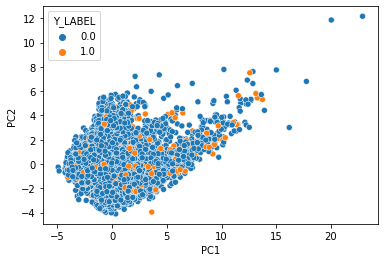

In [76]:
sns.scatterplot(data=df,x='PC1',y='PC2',hue='Y_LABEL')

In [77]:
import plotly.express as px
from sklearn.decomposition import PCA


pca = PCA(n_components=3)
components = pca.fit_transform(train_X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=train_y,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [78]:
pca = PCA(n_components=3)
components = pca.fit_transform(val_X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=val_y,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [79]:
import pickle

#저장하기
with open(f"./data/{file_version}_refined_train_X", 'wb') as pickle_filename:
	pickle.dump(train_X, pickle_filename)

with open(f"./data/{file_version}_refined_train_y", 'wb') as pickle_filename:
	pickle.dump(train_y, pickle_filename)
    
with open(f"./data/{file_version}_refined_val_X", 'wb') as pickle_filename:
	pickle.dump(val_X, pickle_filename)

with open(f"./data/{file_version}_refined_val_y", 'wb') as pickle_filename:
	pickle.dump(val_y, pickle_filename)
    
with open(f"./data/{file_version}_refined_test", 'wb') as pickle_filename:
	pickle.dump(test, pickle_filename)